# Передсказание возраста по фото с помощью сверточных нейросетей (ResNet)

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

Для начала загрузим данные о возрасте и расположении изображений и посмотрим на размер выборки:

In [2]:
train_path = pd.read_csv("/content/drive/MyDrive/colab/age_determination/train.csv")
train_path.info()
train_path

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5613 entries, 0 to 5612
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  5613 non-null   object
 1   real_age   5613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.8+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
5608,005608.jpg,12
5609,005609.jpg,30
5610,005610.jpg,42
5611,005611.jpg,13


In [3]:
valid_path = pd.read_csv("/content/drive/MyDrive/colab/age_determination/valid.csv")
valid_path.info()
valid_path

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  1000 non-null   object
 1   real_age   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


,file_name,real_age
0,005613.jpg,19
1,005614.jpg,76
2,005615.jpg,40
3,005616.jpg,21
4,005617.jpg,34
...,...,...
995,006613.jpg,27
996,006614.jpg,38
997,006615.jpg,28
998,006616.jpg,38


In [4]:
test_path = pd.read_csv("/content/drive/MyDrive/colab/age_determination/test.csv")
test_path.info()
test_path

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  978 non-null    object
 1   real_age   978 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 15.4+ KB


,file_name,real_age
0,006618.jpg,13
1,006619.jpg,36
2,006620.jpg,16
3,006621.jpg,46
4,006622.jpg,60
...,...,...
973,007608.jpg,14
974,007609.jpg,37
975,007610.jpg,28
976,007611.jpg,20


В нашем распоряжении 5613 объектов в тренировочной выборке, 1000 в валидационной и 978 в тестовой. 

Теперь посмотрим на распределение возраста в выборке:

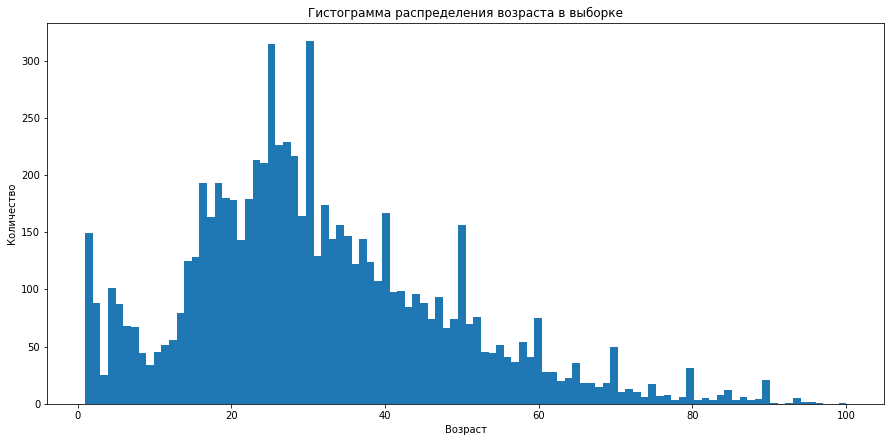

In [5]:
full_data = pd.concat([train_path,valid_path,test_path])
plt.figure(figsize=(15,7))
plt.title('Гистограмма распределения возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.hist(full_data['real_age'], bins=100)
plt.show()

В нашем датасете большинство составляют люди от 16 до 40 лет. 

При увеличении возраста, начиная с 30 лет, количество примеров уменьшается. 

А вот для детей младше 16, в частности 1-10 лет, примеров относительно много.

Есть аномальное проявление пиков каждые 10 лет начиная с 30 лет. Скорее всего это связано с одним из источников данных, где возраст был округлен до десятка.

Теперь загрузим сами изображения с помощью ImageDataGenerator и посмотрим на них:

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 7 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 5606 validated image filenames.


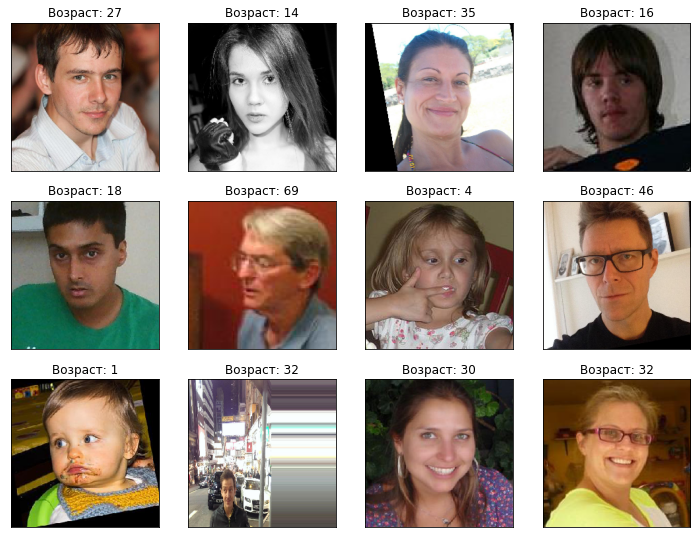

In [6]:
example_datagen = ImageDataGenerator(rescale=1./255.)

example_datagen_flow = example_datagen.flow_from_dataframe(train_path, 
                                            x_col='file_name', 
                                            y_col='real_age', 
                                            directory="/content/drive/MyDrive/colab/age_determination/train",
                                            target_size=(224, 224), 
                                            batch_size=32, 
                                            class_mode="raw", 
                                            seed=12345)

features, target = next(example_datagen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title("Возраст: "+str(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Датасет содержит изображения людей в разной обстановке, разного внешнего вида. Все изображения содержат лицо примерно в центре. 

### Обзор данных

Количество примеров для обучения кажется достаточным для данной задачи, но для увеличения размера выборки используем аугментацию - отражение по горизонтали. Сами изображения отцентрованы по лицу и часть имеют небольшие углы поворота. Также датасет имеет часть черных-белых изображений, что может немного запутать модель.

Могут возникнуть проблемы с точным определением возраста для людей 8-16 лет и 50+ лет из-за малого количества примеров, относительно других возрастных групп. 

Также по гистограмме видны пики каждые 10 лет начиная с 30, что говорит о неточности разметки и может плохо повлиять на качество обучения.

## Обучение модели

Теперь займемся обучением модели. 

Для начала настроим загрузчики тренировочной и валидационной выборки.

В качестве аугментаций для увеличения объема тренировочной выборки используем горизонатальное отражение:

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255., horizontal_flip=True, rotation_range=15, 
		width_shift_range=.15, height_shift_range=.15, zoom_range=0.1)

train_datagen_flow = train_datagen.flow_from_dataframe(train_path, 
                                            x_col='file_name', 
                                            y_col='real_age',
                                            directory="/content/drive/MyDrive/colab/age_determination/train",
                                            target_size=(224, 224), 
                                            batch_size=32, 
                                            class_mode="raw", 
                                            seed=12345)


    
valid_datagen = ImageDataGenerator(rescale=1./255.)

valid_datagen_flow = valid_datagen.flow_from_dataframe(valid_path, 
                                            x_col='file_name', 
                                            y_col='real_age',
                                            directory="/content/drive/MyDrive/colab/age_determination/valid",
                                            target_size=(224, 224), 
                                            batch_size=32, 
                                            class_mode="raw", 
                                            seed=12345)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 7 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 5606 validated image filenames.
Found 1000 validated image filenames.


В качестве основы для модели используем сеть ResNet50 и заменими последние слои на четыре полносвязных слоя с ReLu-активацией, добавив Dropout-регуляризацию на выходе. Возьмем исходные веса с датасета ImageNet и обучим сеть за 25 эпох.

In [8]:
optimizer = Adam(lr=0.0005)
backbone = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)

model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 24,768,385
Trainable params: 24,715,265
Non-trainable params: 53,120
_______________________________________

Сеть получилась довольно сложная: 24 млн. параметров.

Теперь проведем обучение:

In [9]:
steps_per_epoch = len(train_datagen_flow)
validation_steps = len(valid_datagen_flow)
model.fit(train_datagen_flow, validation_data=valid_datagen_flow, epochs=30,
               steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

Epoch 1/30
176/176 - 164s - loss: 205.9582 - mae: 11.0387 - val_loss: 643.1949 - val_mae: 19.4257
Epoch 2/30
176/176 - 147s - loss: 146.5624 - mae: 9.3003 - val_loss: 566.6793 - val_mae: 17.9248
Epoch 3/30
176/176 - 148s - loss: 133.9729 - mae: 8.8768 - val_loss: 350.1143 - val_mae: 13.9746
Epoch 4/30
176/176 - 147s - loss: 114.4997 - mae: 8.1969 - val_loss: 391.3825 - val_mae: 14.6163
Epoch 5/30
176/176 - 149s - loss: 116.5870 - mae: 8.1843 - val_loss: 212.7357 - val_mae: 10.3740
Epoch 6/30
176/176 - 148s - loss: 109.5382 - mae: 7.9982 - val_loss: 324.7523 - val_mae: 13.1175
Epoch 7/30
176/176 - 148s - loss: 98.0539 - mae: 7.5596 - val_loss: 123.7845 - val_mae: 8.2867
Epoch 8/30
176/176 - 149s - loss: 97.6122 - mae: 7.5263 - val_loss: 304.5232 - val_mae: 12.8174
Epoch 9/30
176/176 - 148s - loss: 92.8611 - mae: 7.3089 - val_loss: 146.3813 - val_mae: 8.9843
Epoch 10/30
176/176 - 147s - loss: 92.5846 - mae: 7.2697 - val_loss: 175.5990 - val_mae: 9.6997
Epoch 11/30
176/176 - 147s - loss: 

Полученная метрика: МАЕ=8.54 на валидации.

Теперь проверим модель на тесте:

In [12]:
test_datagen = ImageDataGenerator(rescale=1./255.)

test_datagen_flow = test_datagen.flow_from_dataframe(test_path, 
                                            x_col='file_name', 
                                            y_col='real_age',
                                            directory="/content/drive/MyDrive/colab/age_determination/test",
                                            target_size=(224, 224), 
                                            batch_size=32, 
                                            class_mode="raw", 
                                            seed=12345)

Found 978 validated image filenames.


In [13]:
loss, mae = model.evaluate(test_datagen_flow, verbose=2)
mae

31/31 - 8s - loss: 130.8021 - mae: 8.0869


8.08690071105957

## Вывод

Получили МАЕ=8.08

Вероятно размер ошибки связан с тем, что данных 50+ лет было меньше остальных и модель недостаточно обучилась на них, а также с тем, что в период 25-40 лет бывает сложно определить точный возраст человека. 

Вероятно выбросы каждые 10 лет тоже сделали свой вклад в точность модели. Кроме этого бывают ситуации когда человек выглядит старше или младше своего реального возраста.

Также существует вероятность переобучения, учитывая такую маленькую метрику на тренировочной выборке.